### 1. 데이터 불러오기 및 확인

In [1]:
import pandas as pd

# 데이터 불러오기
mall = pd.read_csv('Mall_Customers.csv')

# 데이터 미리보기
mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
# 데이터 정보확인
mall.info()
print('\n--------결측치 확인--------')
print(mall.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

--------결측치 확인--------
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


### 2. 데이터 전처리

#### 데이터 분석에 사용하지 않는 컬럼 제거

In [3]:
# 분석에 사용하지 않는 컬럼 제거
mall = mall.drop(columns=['CustomerID', 'Gender'])
mall

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


#### 이상치 확인 및 처리

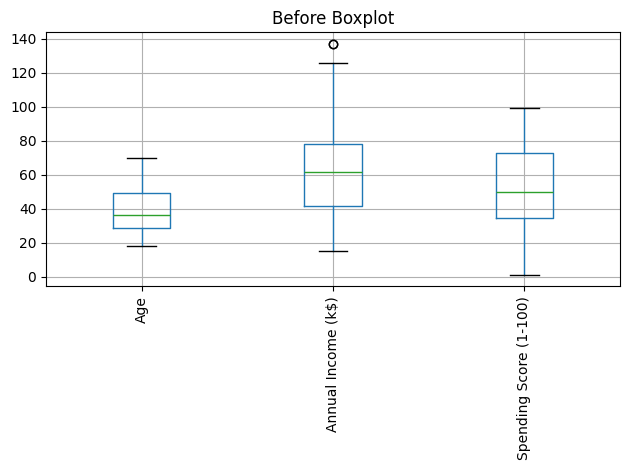

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# 이상치 처리 전 데이터 시각화
mall.boxplot()
plt.xticks(rotation=90)
plt.title('Before Boxplot')
plt.tight_layout()
plt.show()

In [5]:
import numpy as np

numerical_columns = mall.select_dtypes(include=[np.number]).columns
mall_processed = mall.copy()

for col in numerical_columns:
    Q1 = mall[col].quantile(0.25)
    Q3 = mall[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((mall[col] < lower_bound) | (mall[col] > upper_bound))
    if outliers.sum() > 0:
        # 이상치를 상한 및 하한값으로 대체
        mall_processed[col] = np.where(mall_processed[col] < lower_bound, lower_bound, mall_processed[col])
        mall_processed[col] = np.where(mall_processed[col] > upper_bound, upper_bound, mall_processed[col])

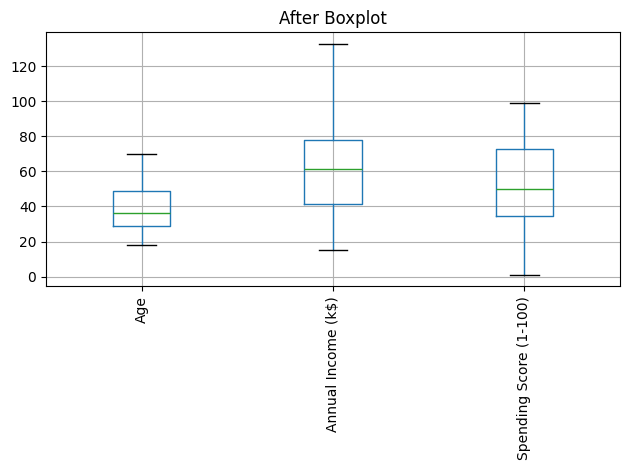

In [6]:
# 이상치 처리 후 데이터 시각화
mall_processed.boxplot()
plt.xticks(rotation=90)
plt.title('After Boxplot')
plt.tight_layout()
plt.show()

#### 스케일링

In [7]:
from sklearn.preprocessing import StandardScaler

# 숫자형 컬럼 선택 및 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(mall_processed[numerical_columns])

### 3. 클러스터링 기법 적용

#### K-means

In [8]:
from sklearn.cluster import KMeans

# 최적의 k찾기 (엘보우 방법)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

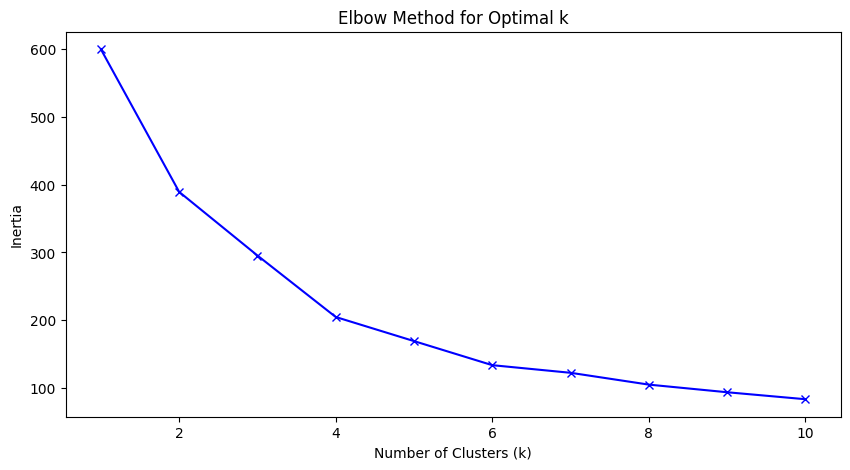

In [9]:
# 엘보우 그래프
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [10]:
from sklearn.metrics import silhouette_score

# 최적 클러스터 수(k = 6)로 모델 생성 및 학습
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)
print(f'실루엣 계수: {kmeans_silhouette}')

실루엣 계수: 0.4319400078999662


In [11]:
# 군집 결과 할당
mall_processed['Cluster'] = kmeans.labels_

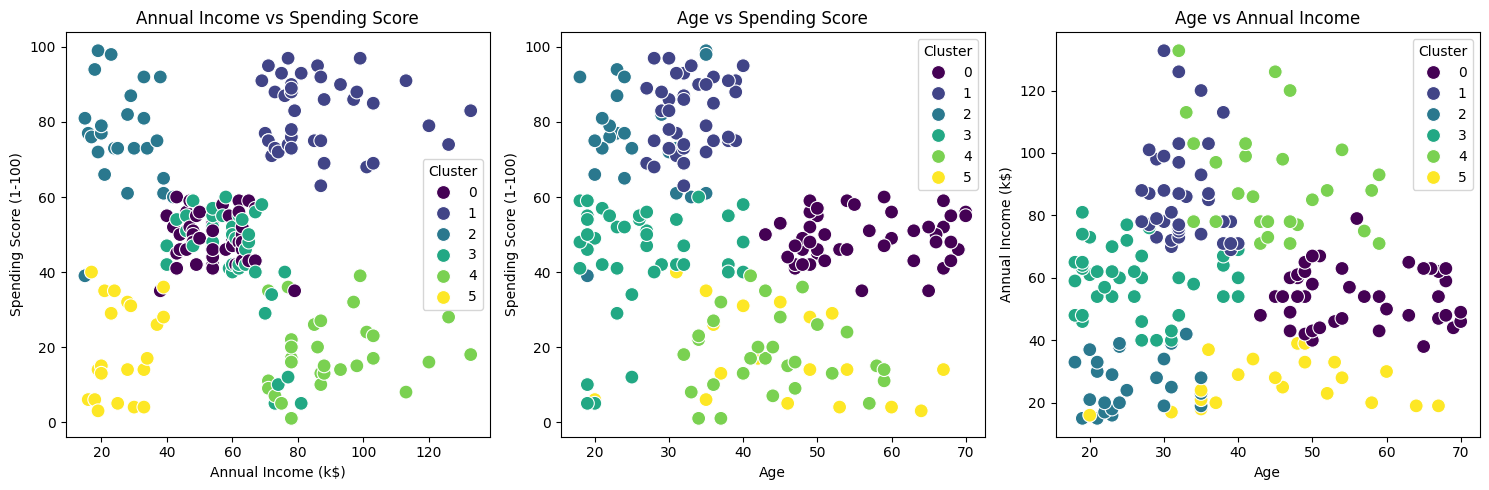

In [12]:
import seaborn as sns

# 2D 시각화 (여러 특성 조합)
plt.figure(figsize=(15, 5))

# 1. Annual Income vs Spending Score
plt.subplot(1, 3, 1)
sns.scatterplot(data=mall_processed, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Annual Income vs Spending Score')

# 2. Age vs Spending Score
plt.subplot(1, 3, 2)
sns.scatterplot(data=mall_processed, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Spending Score')

# 3. Age vs Annual Income
plt.subplot(1, 3, 3)
sns.scatterplot(data=mall_processed, x='Age', y='Annual Income (k$)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Annual Income')

plt.tight_layout()
plt.show()

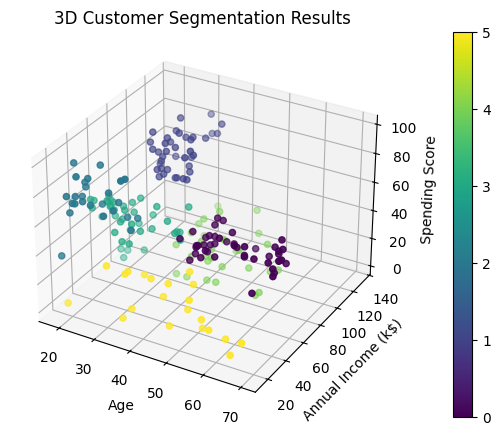

In [13]:
# 3D 시각화
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(mall_processed['Age'], 
                    mall_processed['Annual Income (k$)'], 
                    mall_processed['Spending Score (1-100)'],
                    c=mall_processed['Cluster'], 
                    cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.title('3D Customer Segmentation Results')
plt.colorbar(scatter)
plt.show()

In [14]:
# 클러스터별 특성 분석
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cluster_means = mall_processed.groupby('Cluster')[features].mean()
print("\n=== 클러스터별 평균값 ===")
print(cluster_means)


=== 클러스터별 평균값 ===
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.333333           54.266667               49.066667
1        32.692308           86.429487               82.128205
2        25.560000           26.480000               76.240000
3        26.125000           59.425000               44.450000
4        44.000000           89.991667               17.933333
5        45.523810           26.285714               19.380952


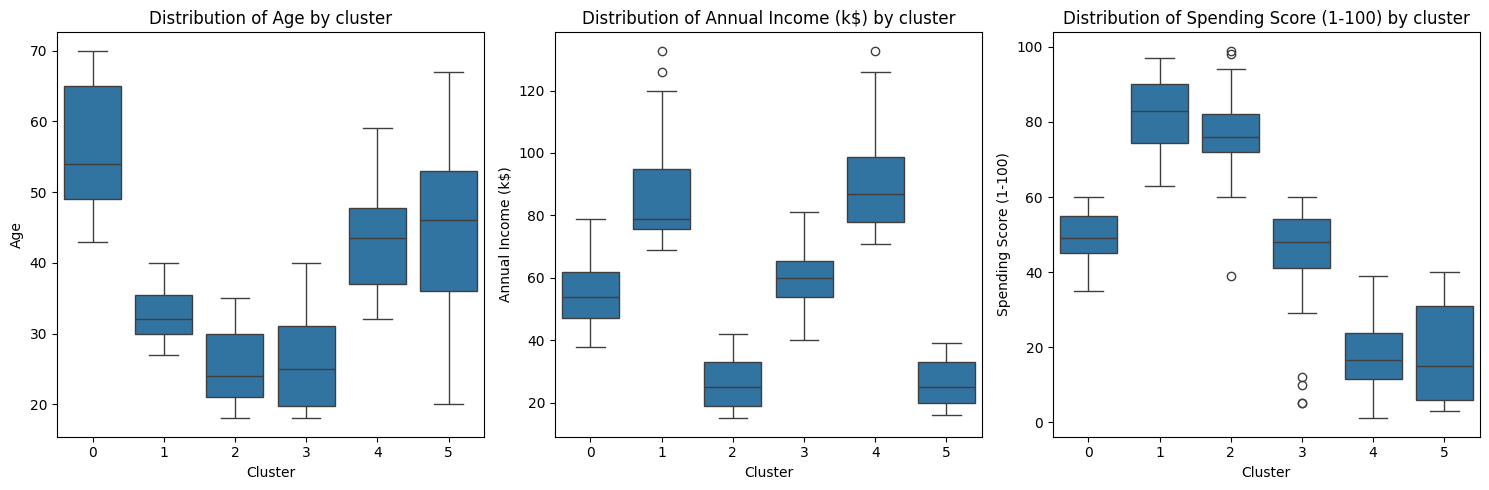

In [15]:
# 클러스터별 특성 분포 시각화
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=mall_processed)
    plt.title(f'Distribution of {feature} by cluster')
plt.tight_layout()
plt.show()

In [16]:
# 클러스터별 특성 요약
print("\n=== 클러스터 특성 요약 ===")
for cluster in sorted(mall_processed['Cluster'].unique()):
    cluster_data = mall_processed[mall_processed['Cluster'] == cluster]
    print(f"\n클러스터 {cluster}:")
    print(f"고객 수: {len(cluster_data)}")
    print("평균값:")
    print(cluster_data[features].mean())
    print("-----"*10)


=== 클러스터 특성 요약 ===

클러스터 0:
고객 수: 45
평균값:
Age                       56.333333
Annual Income (k$)        54.266667
Spending Score (1-100)    49.066667
dtype: float64
--------------------------------------------------

클러스터 1:
고객 수: 39
평균값:
Age                       32.692308
Annual Income (k$)        86.429487
Spending Score (1-100)    82.128205
dtype: float64
--------------------------------------------------

클러스터 2:
고객 수: 25
평균값:
Age                       25.56
Annual Income (k$)        26.48
Spending Score (1-100)    76.24
dtype: float64
--------------------------------------------------

클러스터 3:
고객 수: 40
평균값:
Age                       26.125
Annual Income (k$)        59.425
Spending Score (1-100)    44.450
dtype: float64
--------------------------------------------------

클러스터 4:
고객 수: 30
평균값:
Age                       44.000000
Annual Income (k$)        89.991667
Spending Score (1-100)    17.933333
dtype: float64
--------------------------------------------------

클러스터 5:
고객 수: 2

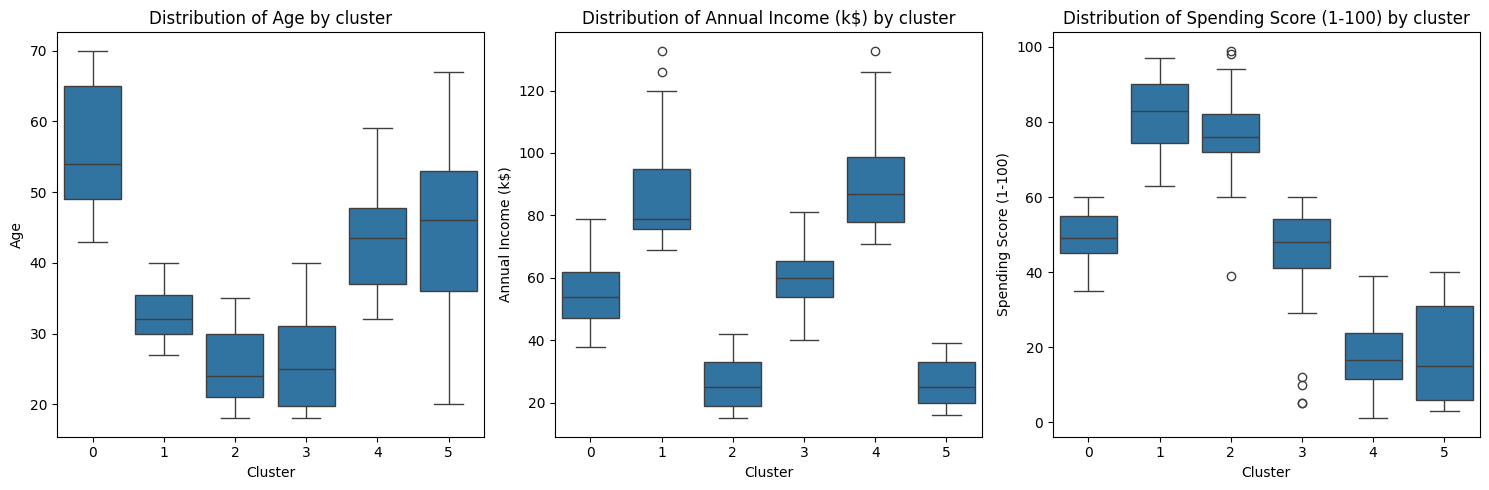

In [17]:
# 클러스터별 특성 분포 시각화
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=mall_processed)
    plt.title(f'Distribution of {feature} by cluster')
plt.tight_layout()
plt.show()

#### 계층적 군집화

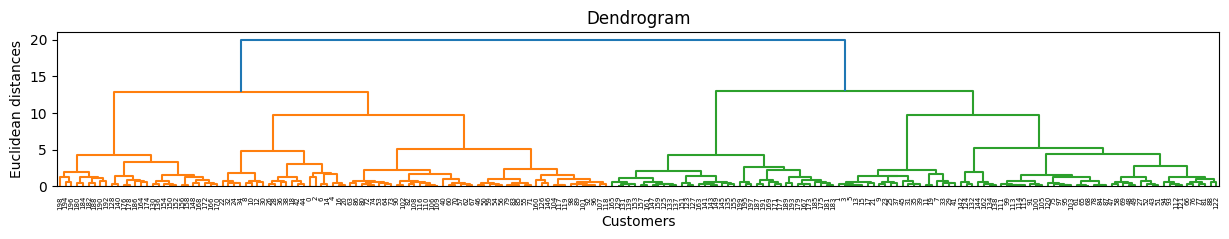

In [18]:
import scipy.cluster.hierarchy as sch

# 덴드로그램 생성
plt.figure(figsize=(15, 2))
dendrogram = sch.dendrogram(sch.linkage(data_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [19]:
from sklearn.cluster import AgglomerativeClustering

# 계층적 군집화 모델 생성
hc = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')

# 모델 학습 및 예측
mall_processed['Cluster'] = hc.fit_predict(mall_processed)

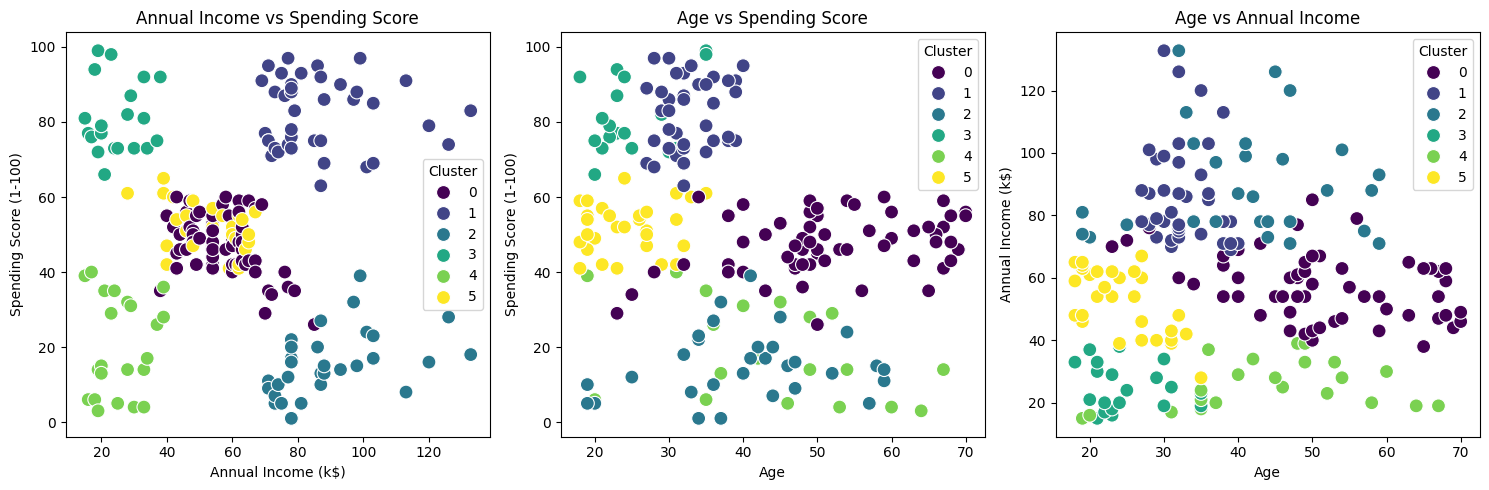

In [20]:
# 2D 시각화 (여러 특성 조합)
plt.figure(figsize=(15, 5))

# 1. Annual Income vs Spending Score
plt.subplot(1, 3, 1)
sns.scatterplot(data=mall_processed, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Annual Income vs Spending Score')

# 2. Age vs Spending Score
plt.subplot(1, 3, 2)
sns.scatterplot(data=mall_processed, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Spending Score')

# 3. Age vs Annual Income
plt.subplot(1, 3, 3)
sns.scatterplot(data=mall_processed, x='Age', y='Annual Income (k$)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Annual Income')

plt.tight_layout()
plt.show()

In [21]:
# 실루엣 계수 계산
hc_silhouette = silhouette_score(data_scaled, mall_processed['Cluster'])
print(f'실루엣 계수: {hc_silhouette}')

실루엣 계수: 0.3947023080201153


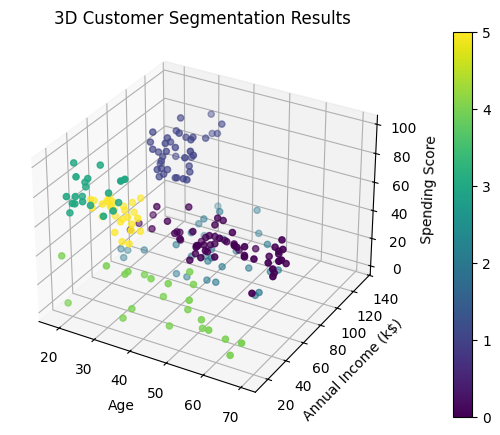

In [22]:
# 3D 시각화
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(mall_processed['Age'], 
                    mall_processed['Annual Income (k$)'], 
                    mall_processed['Spending Score (1-100)'],
                    c=mall_processed['Cluster'], 
                    cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.title('3D Customer Segmentation Results')
plt.colorbar(scatter)
plt.show()

In [23]:
# 클러스터별 특성 분석
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cluster_means = mall_processed.groupby('Cluster')[features].mean()
print("\n=== 클러스터별 평균값 ===")
print(cluster_means)


=== 클러스터별 평균값 ===
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        51.728814           57.271186               47.338983
1        32.692308           86.429487               82.128205
2        40.709677           89.411290               15.258065
3        24.850000           24.950000               81.000000
4        44.318182           25.772727               20.272727
5        24.448276           52.275862               51.896552


In [24]:

# 클러스터별 고객 수
cluster_sizes = mall_processed['Cluster'].value_counts().sort_index()
print("\n=== 클러스터별 고객 수 ===")
print(cluster_sizes)


=== 클러스터별 고객 수 ===
Cluster
0    59
1    39
2    31
3    20
4    22
5    29
Name: count, dtype: int64


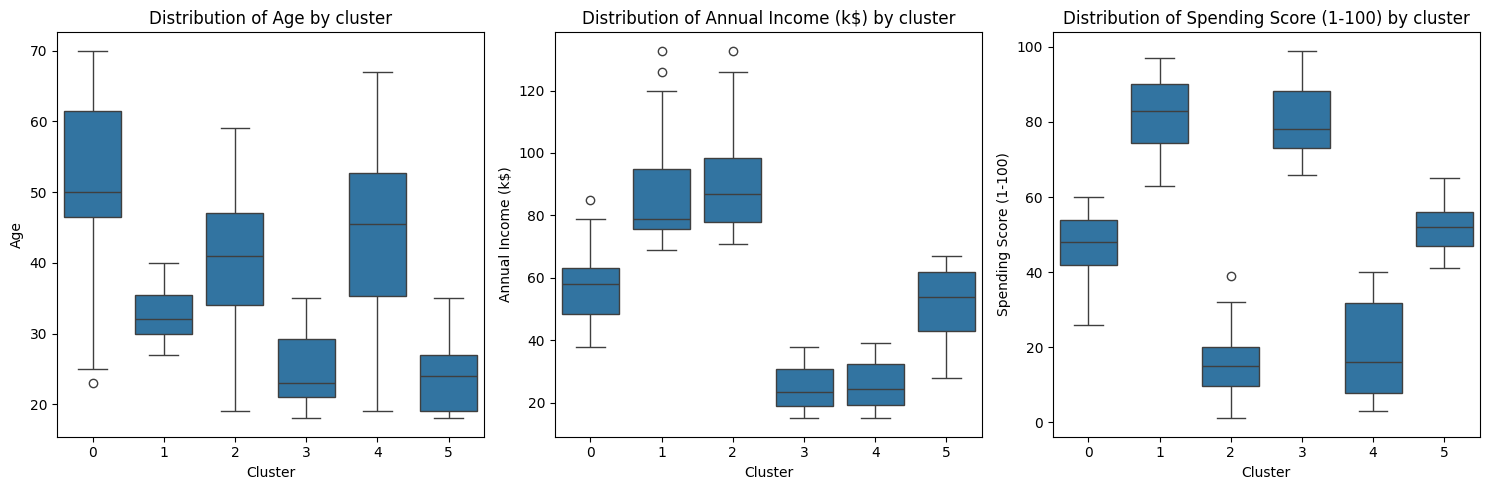

In [25]:
# 클러스터별 특성 분포 시각화
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=mall_processed)
    plt.title(f'Distribution of {feature} by cluster')
plt.tight_layout()
plt.show()

In [26]:

# 클러스터별 특성 요약
print("\n=== 클러스터 특성 요약 ===")
for cluster in sorted(mall_processed['Cluster'].unique()):
    cluster_data = mall[mall_processed['Cluster'] == cluster]
    print(f"\n클러스터 {cluster}:")
    print(f"고객 수: {len(cluster_data)}")
    print("평균값:")
    print(cluster_data[features].mean())
    print("-----"*10)


=== 클러스터 특성 요약 ===

클러스터 0:
고객 수: 59
평균값:
Age                       51.728814
Annual Income (k$)        57.271186
Spending Score (1-100)    47.338983
dtype: float64
--------------------------------------------------

클러스터 1:
고객 수: 39
평균값:
Age                       32.692308
Annual Income (k$)        86.538462
Spending Score (1-100)    82.128205
dtype: float64
--------------------------------------------------

클러스터 2:
고객 수: 31
평균값:
Age                       40.709677
Annual Income (k$)        89.548387
Spending Score (1-100)    15.258065
dtype: float64
--------------------------------------------------

클러스터 3:
고객 수: 20
평균값:
Age                       24.85
Annual Income (k$)        24.95
Spending Score (1-100)    81.00
dtype: float64
--------------------------------------------------

클러스터 4:
고객 수: 22
평균값:
Age                       44.318182
Annual Income (k$)        25.772727
Spending Score (1-100)    20.272727
dtype: float64
--------------------------------------------------

클러스터 5

#### DBSCAN

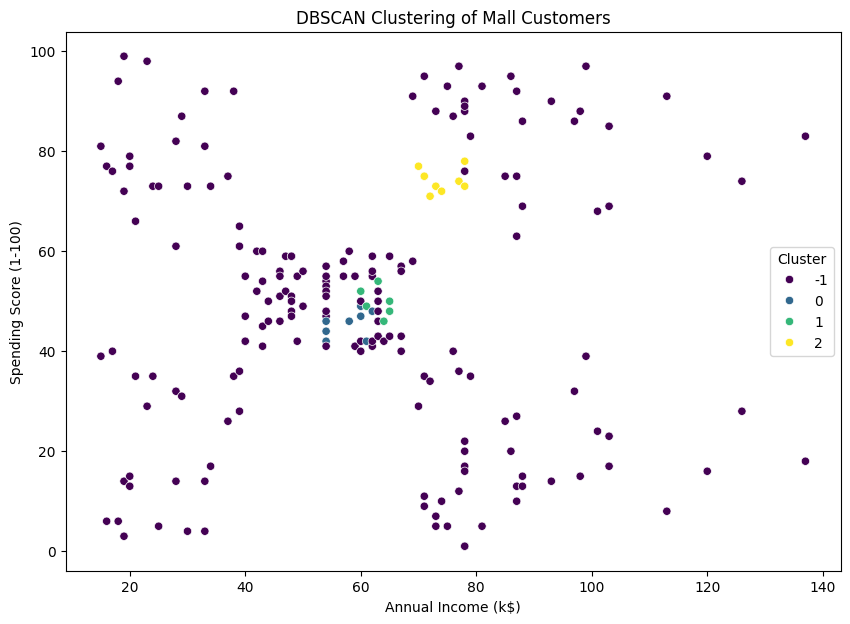

In [27]:
from sklearn.cluster import DBSCAN

# DBSCAN 모델 생성
dbscan = DBSCAN(eps=6, min_samples=6)

# 모델 학습 및 예측
mall['Cluster'] = dbscan.fit_predict(mall_processed)

# 군집화 결과 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=mall, palette='viridis')
plt.title('DBSCAN Clustering of Mall Customers')
plt.show()

In [28]:
# 실루엣 계수 계산
DBSCAN_silhouette = silhouette_score(data_scaled, mall_processed['Cluster'])
print(f'실루엣 계수: {DBSCAN_silhouette}')

실루엣 계수: 0.3947023080201153


##### 파라미터 튜닝

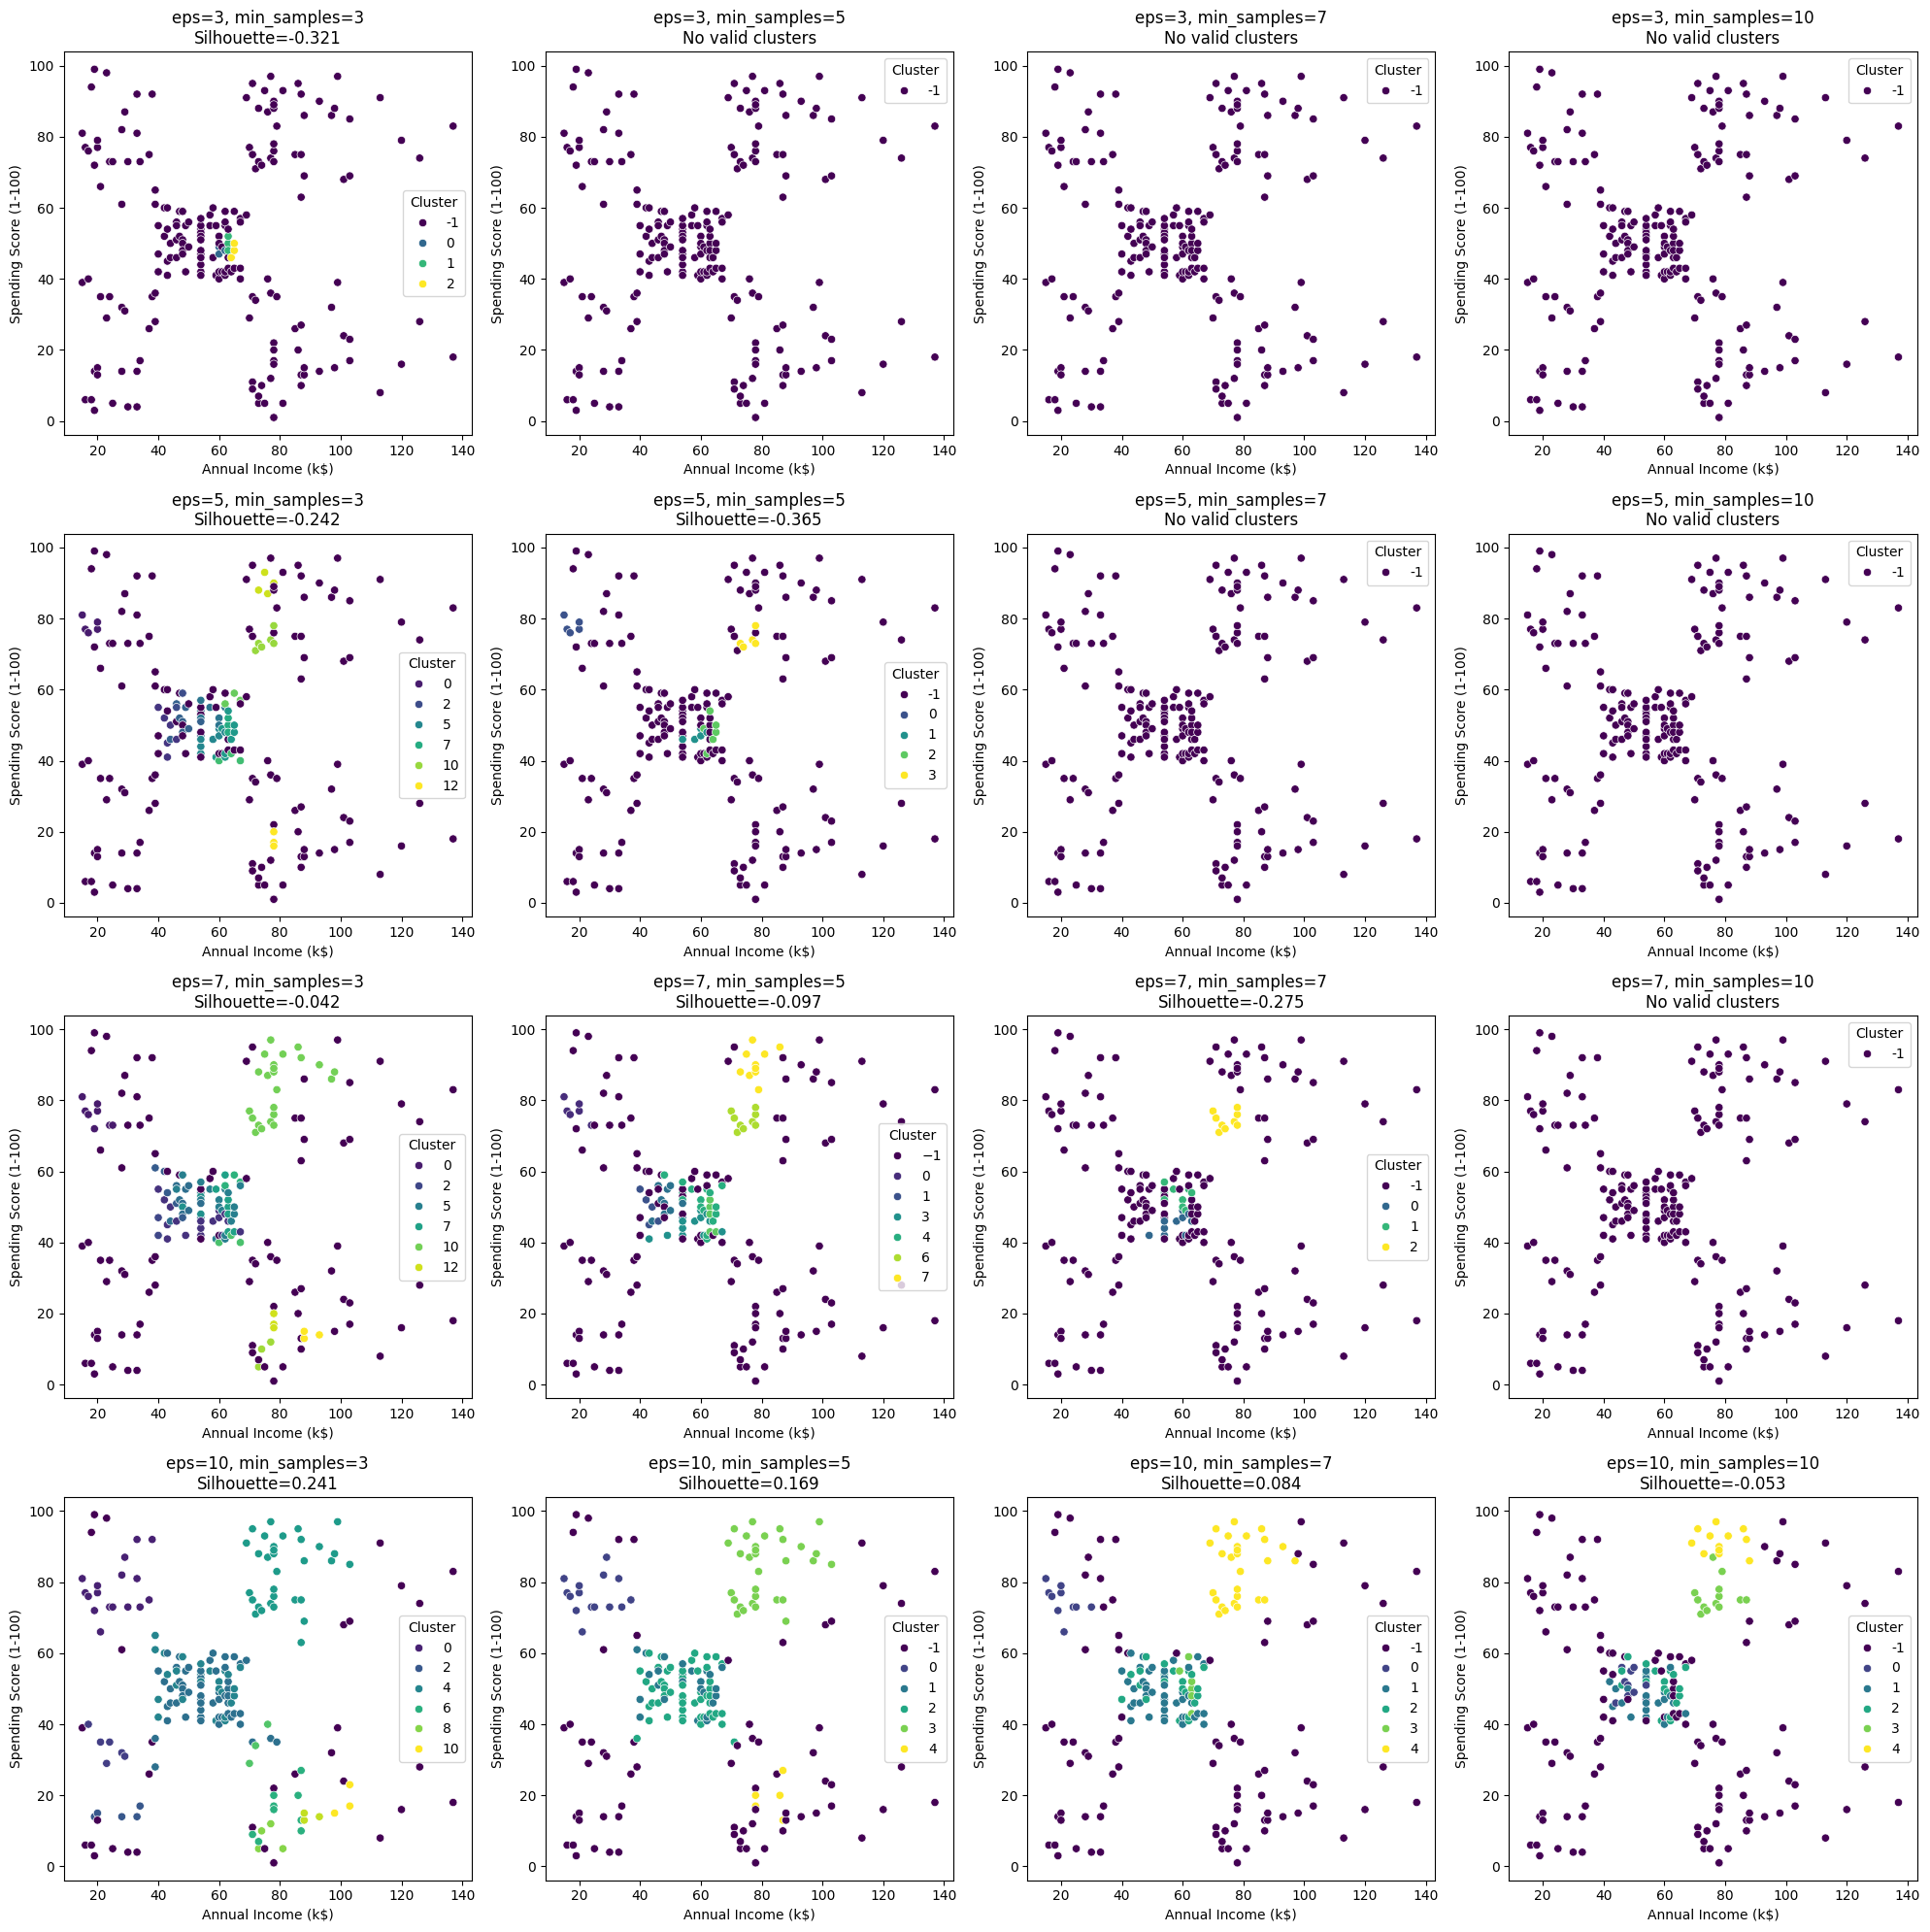

In [29]:
# 다양한 eps와 min_samples 값 시도
eps_values = [3, 5, 7, 10]
min_samples_values = [3, 5, 7, 10]

# 4x4 서브플롯 생성
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # 4행 4열 서브플롯

# eps와 min_samples 값에 대해 반복하면서 그래프를 서브플롯에 추가
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        ax = axes[i, j]  # 각 서브플롯에 그래프 추가
        # DBSCAN 클러스터링 수행
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(mall_processed)
        mall['Cluster'] = labels

        # 실루엣 계수 계산 (노이즈 포인트 제외)
        if len(set(labels)) > 1:  # 클러스터가 2개 이상인 경우
            silhouette_avg = silhouette_score(mall_processed, labels)
            title = f'eps={eps}, min_samples={min_samples}\nSilhouette={silhouette_avg:.3f}'
        else:
            title = f'eps={eps}, min_samples={min_samples}\nNo valid clusters'
        
        # 해당 서브플롯에 그래프 그리기
        sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=mall, palette='viridis', ax=ax)
        ax.set_title(title)

plt.tight_layout()
plt.show()

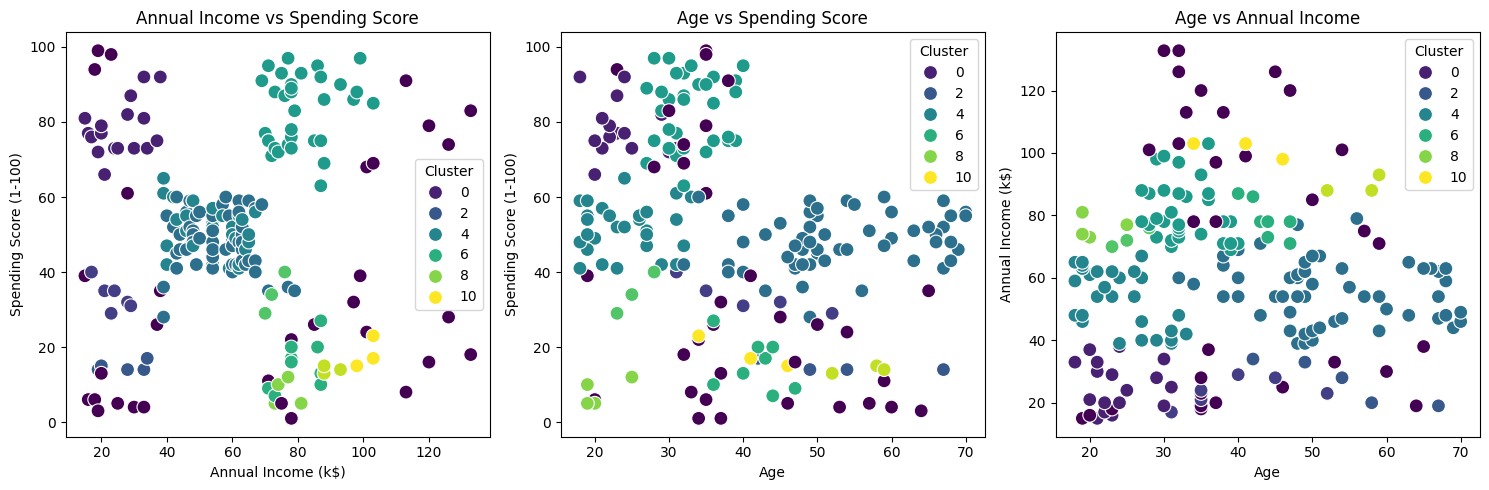

In [30]:
# 최적의 파라미터로 DBSCAN 클러스터링 수행
best_dbscan = DBSCAN(eps=10, min_samples=3)
mall_processed['Cluster'] = best_dbscan.fit_predict(mall_processed)

# 2D 시각화 (여러 특성 조합)
plt.figure(figsize=(15, 5))

# 1. Annual Income vs Spending Score
plt.subplot(1, 3, 1)
sns.scatterplot(data=mall_processed, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Annual Income vs Spending Score')

# 2. Age vs Spending Score
plt.subplot(1, 3, 2)
sns.scatterplot(data=mall_processed, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Spending Score')

# 3. Age vs Annual Income
plt.subplot(1, 3, 3)
sns.scatterplot(data=mall_processed, x='Age', y='Annual Income (k$)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Annual Income')

plt.tight_layout()
plt.show()

In [31]:
# 실루엣 계수 계산
best_DBSCAN_silhouette = silhouette_score(data_scaled, mall_processed['Cluster'])
print(f'실루엣 계수: {best_DBSCAN_silhouette}')

실루엣 계수: 0.21265792431261119


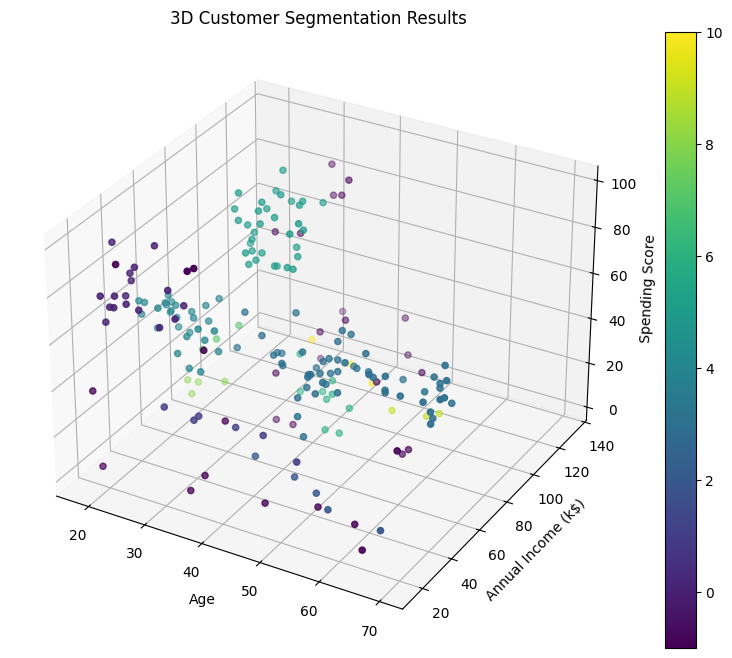

In [32]:
# 3D 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(mall_processed['Age'], 
                    mall_processed['Annual Income (k$)'], 
                    mall_processed['Spending Score (1-100)'],
                    c=mall_processed['Cluster'], 
                    cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.title('3D Customer Segmentation Results')
plt.colorbar(scatter)
plt.show()

In [33]:
# 클러스터별 특성 분석
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cluster_means = mall_processed.groupby('Cluster')[features].mean()
print("\n=== 클러스터별 평균값 ===")
print(cluster_means)


=== 클러스터별 평균값 ===
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
-1       39.939394           69.348485               36.000000
 0       23.764706           25.823529               78.176471
 1       39.666667           23.666667               33.666667
 2       54.000000           26.800000               14.800000
 3       52.821429           55.642857               48.089286
 4       24.071429           53.142857               51.571429
 5       32.727273           81.060606               83.000000
 6       42.111111           80.555556               15.444444
 7       25.333333           72.666667               34.333333
 8       20.750000           76.250000                8.000000
 9       56.333333           89.666667               14.000000
 10      40.333333          101.333333               18.333333


In [34]:

# 클러스터별 고객 수
cluster_sizes = mall_processed['Cluster'].value_counts().sort_index()
print("\n=== 클러스터별 고객 수 ===")
print(cluster_sizes)


=== 클러스터별 고객 수 ===
Cluster
-1     33
 0     17
 1      6
 2      5
 3     56
 4     28
 5     33
 6      9
 7      3
 8      4
 9      3
 10     3
Name: count, dtype: int64


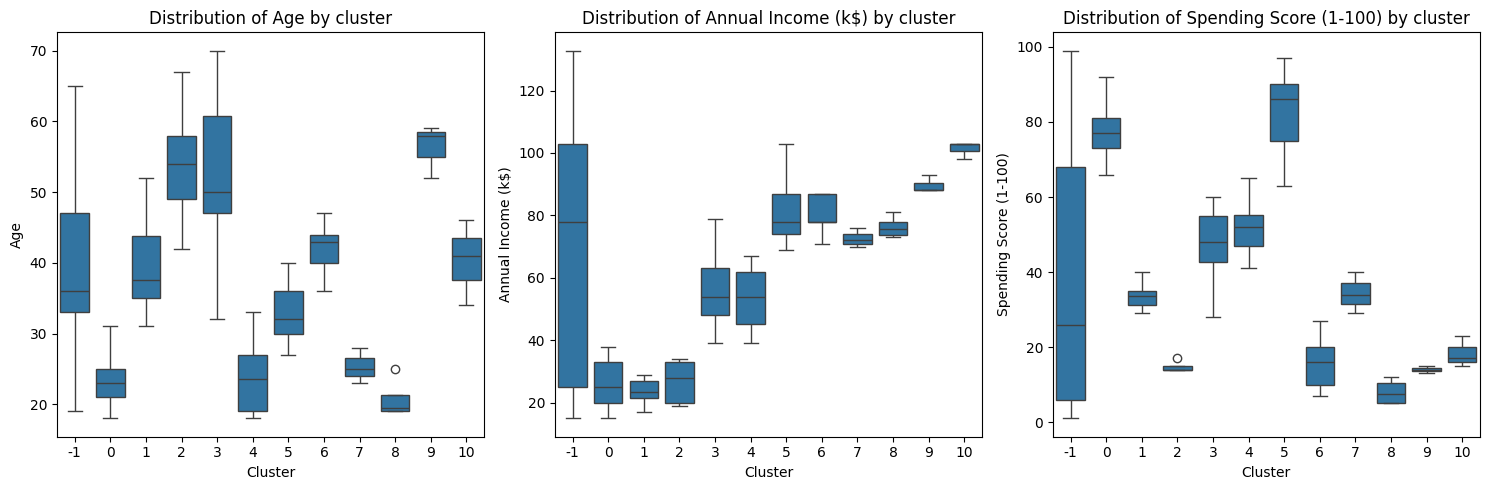

In [35]:

# 클러스터별 특성 분포 시각화
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=mall_processed)
    plt.title(f'Distribution of {feature} by cluster')
plt.tight_layout()
plt.show()

In [36]:

# 클러스터별 특성 요약
print("\n=== 클러스터 특성 요약 ===")
for cluster in sorted(mall_processed['Cluster'].unique()):
    cluster_data = mall[mall_processed['Cluster'] == cluster]
    print(f"\n클러스터 {cluster}:")
    print(f"고객 수: {len(cluster_data)}")
    print("평균값:")
    print(cluster_data[features].mean())
    print("-----"*10)


=== 클러스터 특성 요약 ===

클러스터 -1:
고객 수: 33
평균값:
Age                       39.939394
Annual Income (k$)        69.606061
Spending Score (1-100)    36.000000
dtype: float64
--------------------------------------------------

클러스터 0:
고객 수: 17
평균값:
Age                       23.764706
Annual Income (k$)        25.823529
Spending Score (1-100)    78.176471
dtype: float64
--------------------------------------------------

클러스터 1:
고객 수: 6
평균값:
Age                       39.666667
Annual Income (k$)        23.666667
Spending Score (1-100)    33.666667
dtype: float64
--------------------------------------------------

클러스터 2:
고객 수: 5
평균값:
Age                       54.0
Annual Income (k$)        26.8
Spending Score (1-100)    14.8
dtype: float64
--------------------------------------------------

클러스터 3:
고객 수: 56
평균값:
Age                       52.821429
Annual Income (k$)        55.642857
Spending Score (1-100)    48.089286
dtype: float64
--------------------------------------------------

클러스터 4:
고객

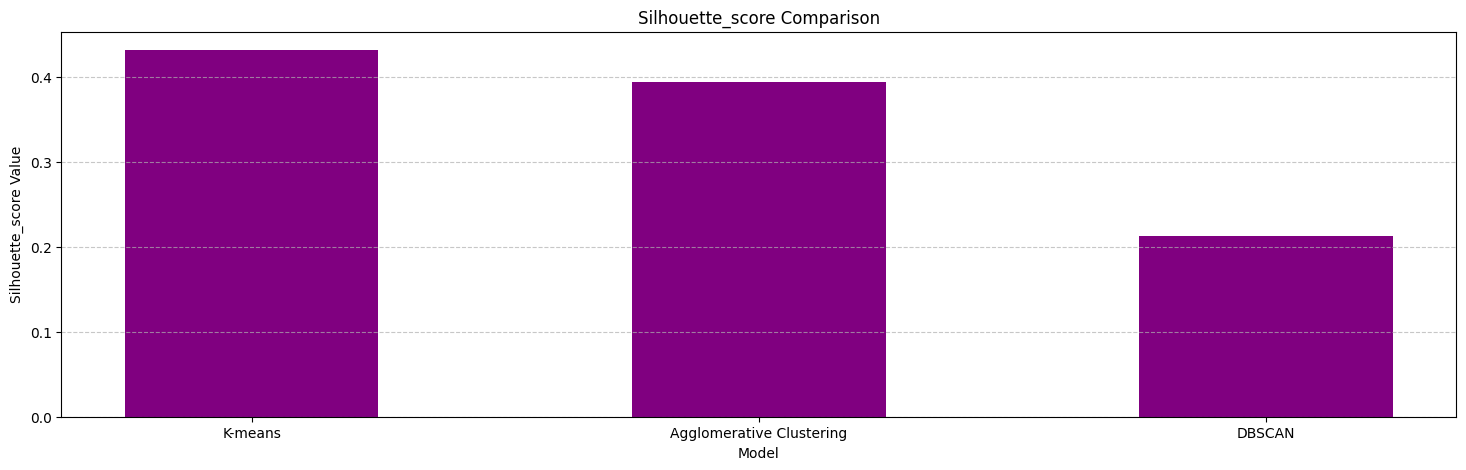

In [37]:
# 모델별 성능 저장
results = pd.DataFrame({
    'Model': ['K-means', 'Agglomerative Clustering', 'DBSCAN'],
    'Silhouette_score': [kmeans_silhouette, hc_silhouette, best_DBSCAN_silhouette]
})

# 서브플롯 생성
fig = plt.figure(figsize=(18, 5))  

plt.bar(results['Model'], results['Silhouette_score'], color='purple', width=0.5)
plt.title('Silhouette_score Comparison')
plt.ylabel('Silhouette_score Value')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정 및 출력
plt.show()